In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from typing import Tuple
from sklearn.linear_model import LinearRegression

sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle':'--'})

In [2]:
# use the auto data as example
auto = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/lectures/lecture_3/auto_mpg.csv")
auto.dropna(inplace=True)
y_min, y_max = 0.8 * auto["mpg"].min(), 1.2 * auto["mpg"].max()

# downsample the data
auto_fit = auto.sample(n=8, random_state=42).reset_index(drop=True)
auto_fit.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car
0,26.0,4.0,96.0,69.0,2189.0,18.0,72.0,2.0,renault 12 (sw)
1,21.6,4.0,121.0,115.0,2795.0,15.7,78.0,2.0,saab 99gle
2,36.1,4.0,91.0,60.0,1800.0,16.4,78.0,3.0,honda civic cvcc
3,26.0,4.0,91.0,70.0,1955.0,20.5,71.0,1.0,plymouth cricket
4,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1.0,ford mustang gl


In [3]:
def hstack_higher_order(X: np.array, order: int = 1):
    """Construct a matrix with higher order terms."""
    X_raw = X.reshape(-1, 1)
    X_w_higher_orders = np.zeros(shape=(len(X_raw), order))
    for o in range(order):
        X_w_higher_orders[:, o] = np.power(X_raw, o).reshape(1, -1)
    return X_w_higher_orders

def fit_polynomial(
    X: np.array,
    y: np.array,
    order: int = 1,
) -> Tuple[int, LinearRegression]:
    """Fit a polynomial model to the underlying data."""
    X_fit = hstack_higher_order(X, order)
    # fit the model
    model = LinearRegression(normalize=False)
    model.fit(X_fit, y)
    
    return order, model

In [4]:
X = auto_fit["horsepower"].values
y = auto_fit["mpg"].values

all_models = []
for order in range(1, 6):
    result = fit_polynomial(X=X, y=y, order=order)
    all_models.append(result)

<IPython.core.display.Javascript object>


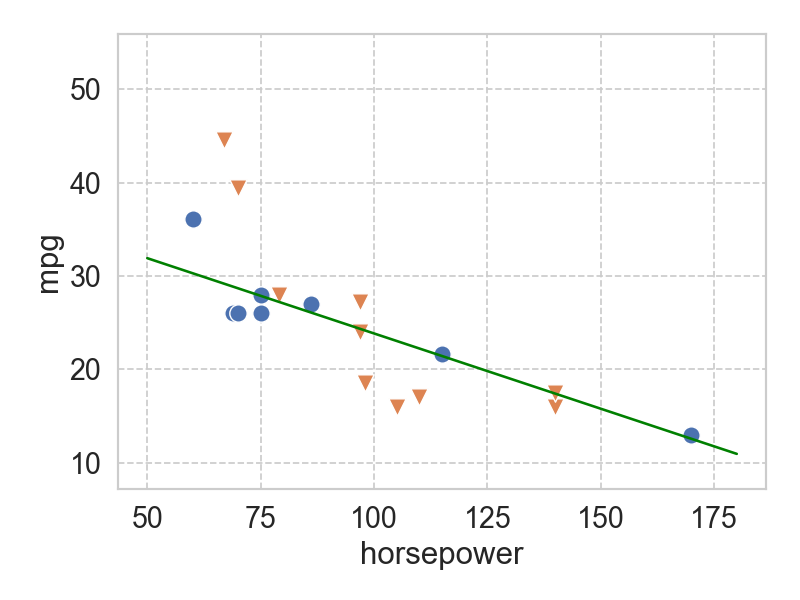

In [5]:
x_plot = np.linspace(start=np.min(X) - 10, stop=np.max(X) + 10, num=100)

plt.figure()
sns.scatterplot(x=X, y=y, s=100)
for order, model in all_models[1:2]:
    x_pred = hstack_higher_order(x_plot, order)
    y_pred = model.predict(x_pred)
    sns.lineplot(x=x_plot, y=y_pred, color="green")

# plot new data
auto_new = auto.sample(n=10, random_state=123).reset_index(drop=True)
sns.scatterplot(x="horsepower", y="mpg", data=auto_new, s=100, marker="v")
plt.gca().set_ylim([y_min, y_max])
plt.tight_layout()
plt.show()

## Cross validation

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = auto["horsepower"].values
y = auto["mpg"].values
n_trials= 10

# CV split
rmse = pd.DataFrame(columns=["trial", "order", "train", "validation"])
for t in range(n_trials):
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=(103 + t))

    # fit different polynomials
    for order in range(1, 8):
        _, model = fit_polynomial(X=X_train, y=y_train, order=order)

        y_pred_train = model.predict(hstack_higher_order(X_train, order))
        y_pred_validation = model.predict(hstack_higher_order(X_validation, order))
        row = {
            "trial": t,
            "order": order,
            "train": np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train)),
            "validation": np.sqrt(mean_squared_error(y_true=y_validation, y_pred=y_pred_validation)),
        }
        rmse = rmse.append(row, ignore_index=True)
rmse

,trial,order,train,validation
0,0.0,1.0,7.894118,7.407799
1,0.0,2.0,4.891589,4.904329
2,0.0,3.0,4.279975,4.661947
3,0.0,4.0,4.276973,4.652892
4,0.0,5.0,4.257462,4.698976
...,...,...,...,...
65,9.0,3.0,4.439830,4.034965
66,9.0,4.0,4.439095,4.022879
67,9.0,5.0,4.420359,4.076875
68,9.0,6.0,4.373246,3.986506


<IPython.core.display.Javascript object>


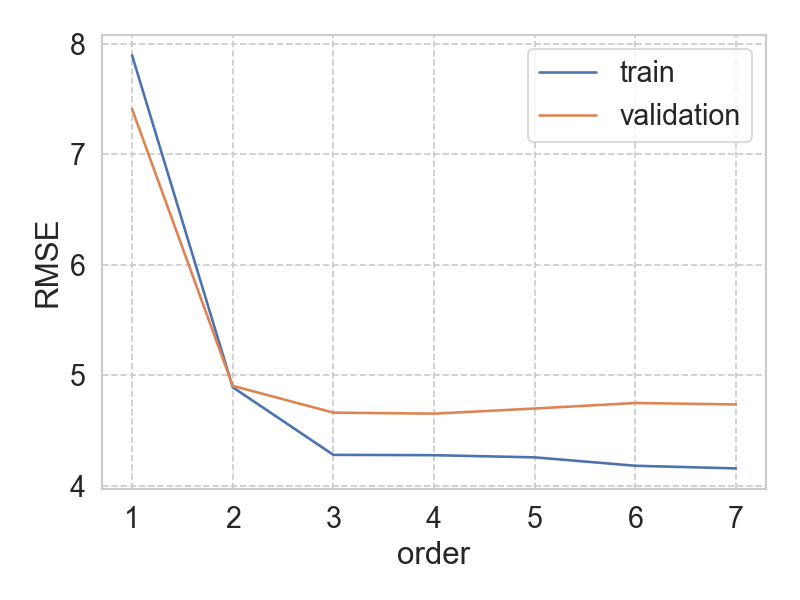

In [7]:
plt.figure()
sns.lineplot(x="order", y="train", data=rmse[rmse["trial"] == 0], label="train")
sns.lineplot(x="order", y="validation", data=rmse[rmse["trial"] == 0], label="validation")

plt.gca().set_ylabel("RMSE")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


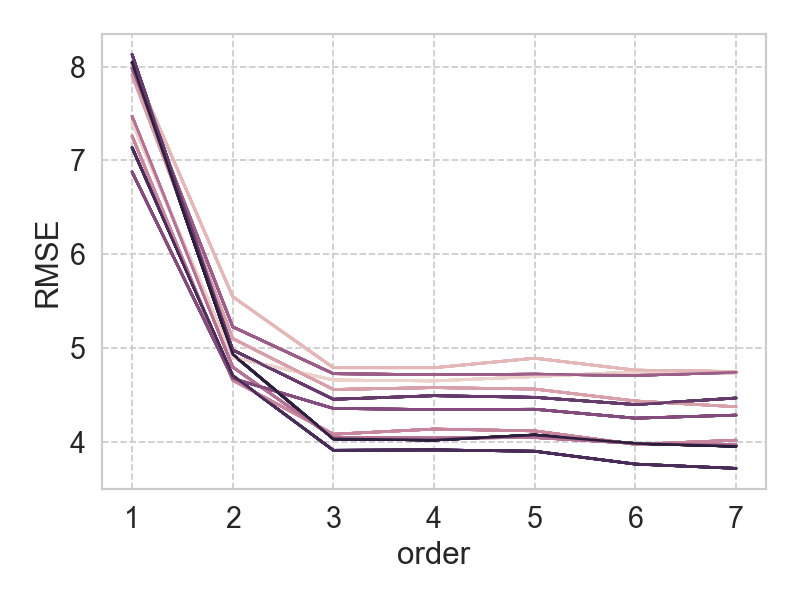

In [8]:
plt.figure()
for t in range(n_trials):
    sns.lineplot(x="order", y="validation", data=rmse, hue="trial")

plt.gca().set_ylabel("RMSE")
plt.gca().get_legend().remove()
plt.tight_layout()
plt.show()